# Rumour Analysis with Covid Data

In [1]:
! pip install spacy seaborn
! python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 13.6 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import string
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

# Loading customization for plots
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading sklearn packages for modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from nltk.corpus import stopwords
stopword = stopwords.words('english')

## Load data

In [5]:
import dataloader

In [69]:
covid_df = dataloader.load_data(data_file = '../data/covid.data.jsonl', label_file = '../data/covid.predicted_label.json', perform_stemming = False)

In [71]:
covid_df['source_tweet'][0]

'according to the new york times  warner bros  wanted to delay christopher nolan s tenet months ago due to the covid    pandemic but nolan refused to listen to any discussions  the studio kept the original release date to  keep [nolan] happy'

In [72]:
covid_df['text'][0]

'according to the new york times  warner bros  wanted to delay christopher nolan s tenet months ago due to the covid    pandemic but nolan refused to listen to any discussions  the studio kept the original release date to  keep [nolan] happy'

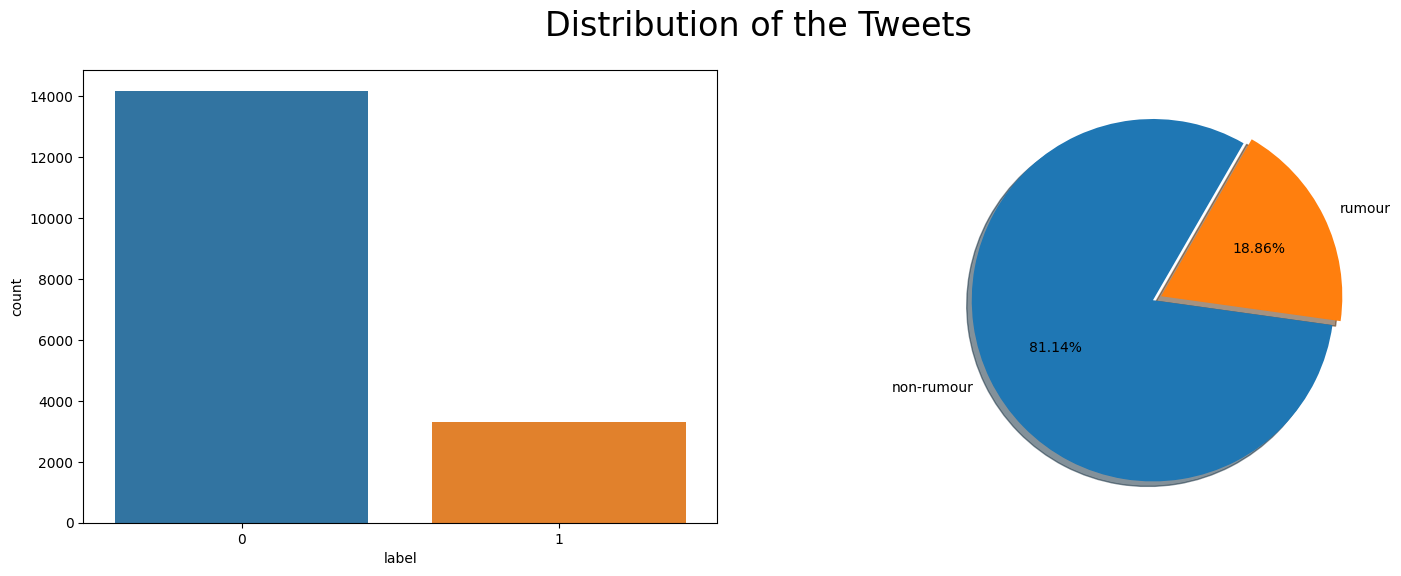

In [73]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(covid_df['label'], ax=axes[0])
axes[1].pie(covid_df['label'].value_counts(),
            labels=['non-rumour', 'rumour'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

## Analysis 1: What are the topics of COVID-19 rumours? How do they differ from the non-rumours? How do these topics evolve over time?

### Character count for tweet chains

In [74]:
covid_df['Character Count'] = covid_df['text'].apply(lambda x: len(str(x)))

In [75]:
def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


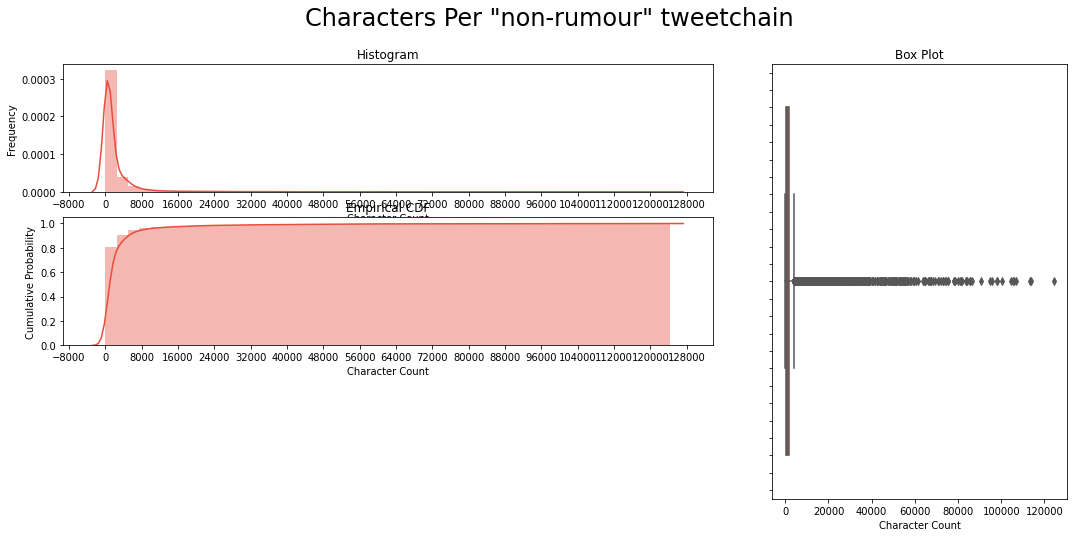

In [76]:
plot_dist3(covid_df, 'Character Count', 'Characters Per "non-rumour" tweetchain')

### Word counts

In [77]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non-Rumour Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Rumour Tweets')
    
    fig.suptitle('Words Per Tweet chain', fontsize=24, va='baseline')
    
    fig.tight_layout()

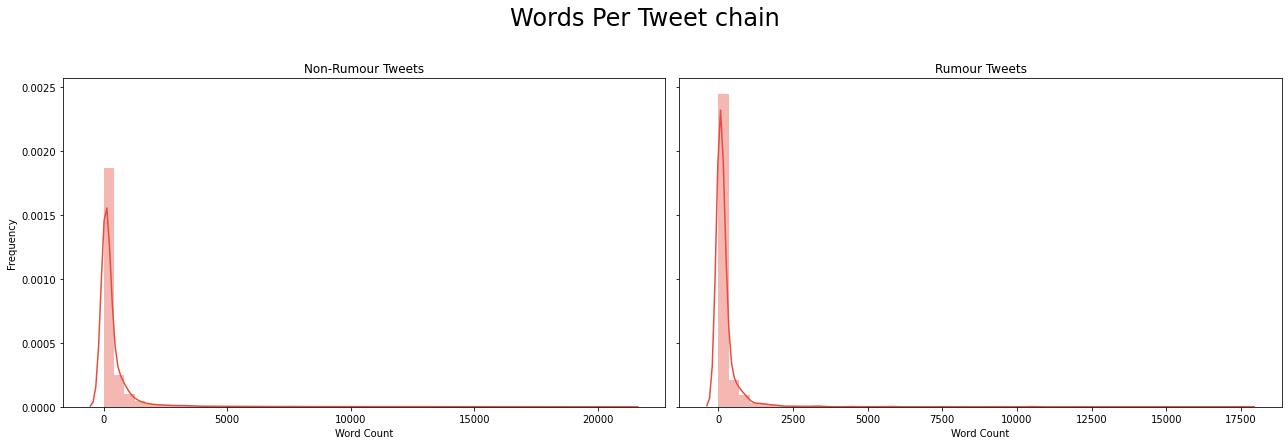

In [78]:
plot_word_number_histogram(covid_df[covid_df['label'] == 0]['text'],
                           covid_df[covid_df['label'] == 1]['text'])


### Most common words in tweet-chains

First I need to lemmatize the texts

In [79]:
nlp = spacy.load("en_core_web_sm")

In [80]:
def lemmatize(text):
    token = []
    result =''
    text = nlp(text)
    for t in text:
        if not t.is_stop and len(t)>2:  
            token.append(t.lemma_)
    result = ' '.join([i for i in token])
    return result

In [81]:
covid_df['lemmatized'] = covid_df['text'].apply(lambda x: lemmatize(x))

In [82]:
covid_df.head()      

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,verified,geo_enabled,has_description,length_description,source_tweet,replies,hashtags,label,Character Count,lemmatized
0,1272262651100434433,according to the new york times warner bros ...,28,280,False,False,0,True,2512,112,...,False,False,True,128,according to the new york times warner bros ...,[],[tenet],1,240,accord new york time warner bro want delay chr...
1,1287153210990395392,hurricane hanna has made landfall in texas t...,545,658,False,True,1,False,94186,5053,...,True,True,True,131,hurricane hanna has made landfall in texas t...,[guess what the cause of death is from a hurri...,[],0,249,hurricane hanna landfall texas storm hit secti...
2,1266555444283179008,monkeys on the loose in india with stolen coro...,83,179,False,True,1,True,782525,26725,...,True,False,True,159,monkeys on the loose in india with stolen coro...,[],[],0,67,monkey loose india steal coronavirus blood sample
3,1257715199655755779,eastleigh and swahili arabs in mombasa where c...,304,2306,False,False,0,False,26895,48,...,False,True,True,149,eastleigh and swahili arabs in mombasa where c...,[let is not play blind that the work is fighti...,[],0,574,eastleigh swahili arab mombasa coronavirus sky...
4,1274338812173393920,if trump felt comfortable having it here then...,856,2113,False,True,1,False,17452,1834,...,True,True,True,142,if trump felt comfortable having it here then...,"[coronavirus is very happy, another said of t...","[coronavirus, trumpscoronavirusrally, barr, ab...",0,4232,trump feel comfortable have comfortable say su...


In [83]:
lis = [
    covid_df[covid_df['label'] == 0]['lemmatized'],
    covid_df[covid_df['label'] == 1]['lemmatized']
]

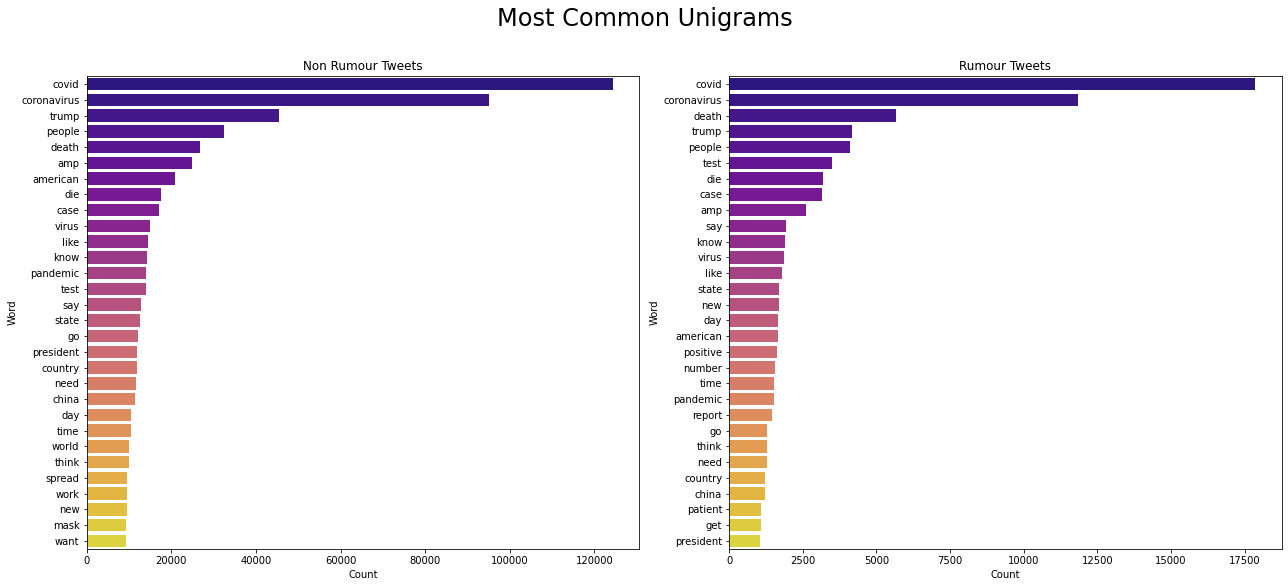

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
    
axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [85]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

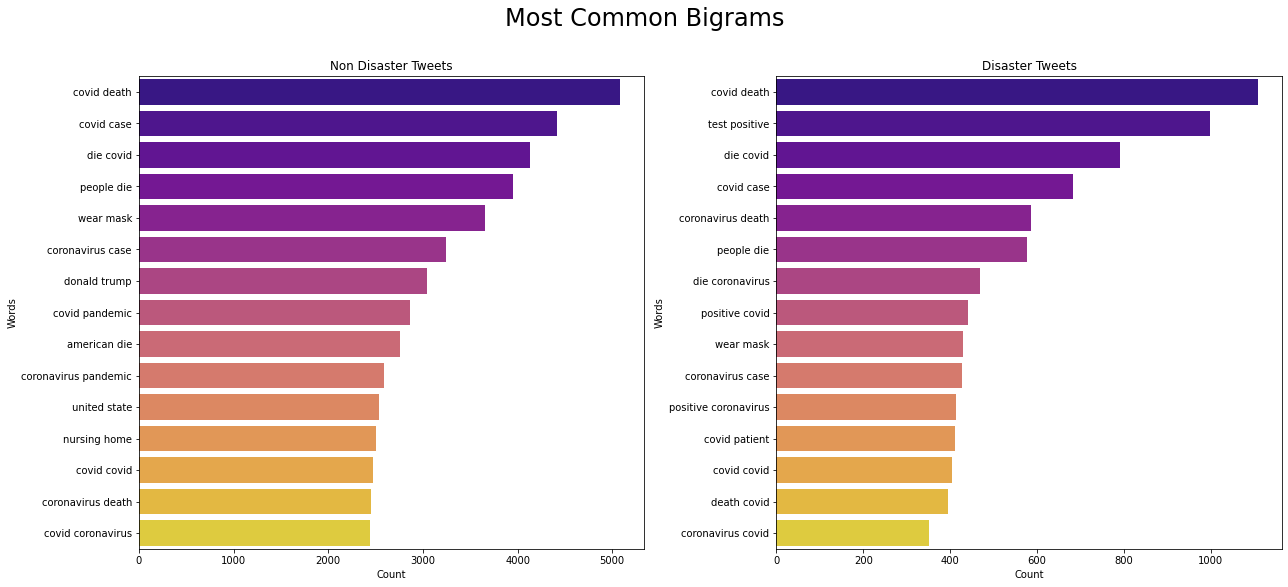

In [86]:
ngrams(2, 'Most Common Bigrams')

### Topic Exploration

We'll be using a method called Non-Negative Matrix Factorization (NMF) to see if we can get some defined topics out of our TF-IDF matrix, with this way TF-IDF will decrease impact of the high frequency words, so we might get more specific topics.

When we inspect our top ten topics we might need to use little imagination to help us understand them. Well actually they are pretty seperable again, I'd say disaster topics are much more clearer to read, we can see the topics directly by looking at them, meanwhile non disaster ones are more personal topics...

In [87]:
def display_topics(text, no_top_words, topic):
    
    """ A function for determining the topics present in our corpus with nmf """
    
    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0,
              alpha=.1, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


display_topics(lis[0], 10, 'Non-Rumour Topics\n')

Non-Rumour Topics

Topic 1:
covid like protest virus die think people know get go
Topic 2:
trump american president coronavirus america amp response lie hoax donald
Topic 3:
coronavirus people like spread think say know virus go get
Topic 4:
china wuhan chinese virus world wuhanvirus ccp country lab blame
Topic 5:
death case number die new state report rate florida day
Topic 6:
mask wear face spread people social distancing protect public amp
Topic 7:
test testing positive result kit case negative day symptom covid
Topic 8:
amp people help pandemic lockdown government need work fight india
Topic 9:
vaccine hydroxychloroquine drug patient fauci study treatment cure doctor flu
Topic 10:
home nursing patient cuomo governor send order elderly stay state


In [88]:
display_topics(lis[1], 10,'Rumour Topics\n')

Rumour Topics

Topic 1:
covid people amp mask virus like know think get time
Topic 2:
case new total report confirm recovery today doh number break
Topic 3:
test positive player negative covid result confirm member coronavirus staff
Topic 4:
death covid number cause report coronavirus toll count week ago
Topic 5:
trump american president lie coronavirus hoax amp rally donald say
Topic 6:
coronavirus break say pandemic like news think bill house time
Topic 7:
china wuhan chinese world virus coronavirus wuhanvirus ccp lab country
Topic 8:
die people old year coronavirus complication covid american flu age
Topic 9:
patient hospital home nursing treat recover care doctor discharge treatment
Topic 10:
state florida governor texas day case reopen desantis report county


### Named-Entity Recognition

Named-Entity recognition is a method for extracting information from text and returns which entities that are present in the text are classified into predefined entity types like "Person", "Place", "Organization", etc. By using NER we can get great insights about the types of entities present in the given text dataset.

When we look our NER results we can get lots of great insights. We can see that in disaster tweets countries, cities, states are much more common than non disaster ones. Again nationality or religious or political group names are more likely to be mentioned in disaster tweets. These are great indicators for us...

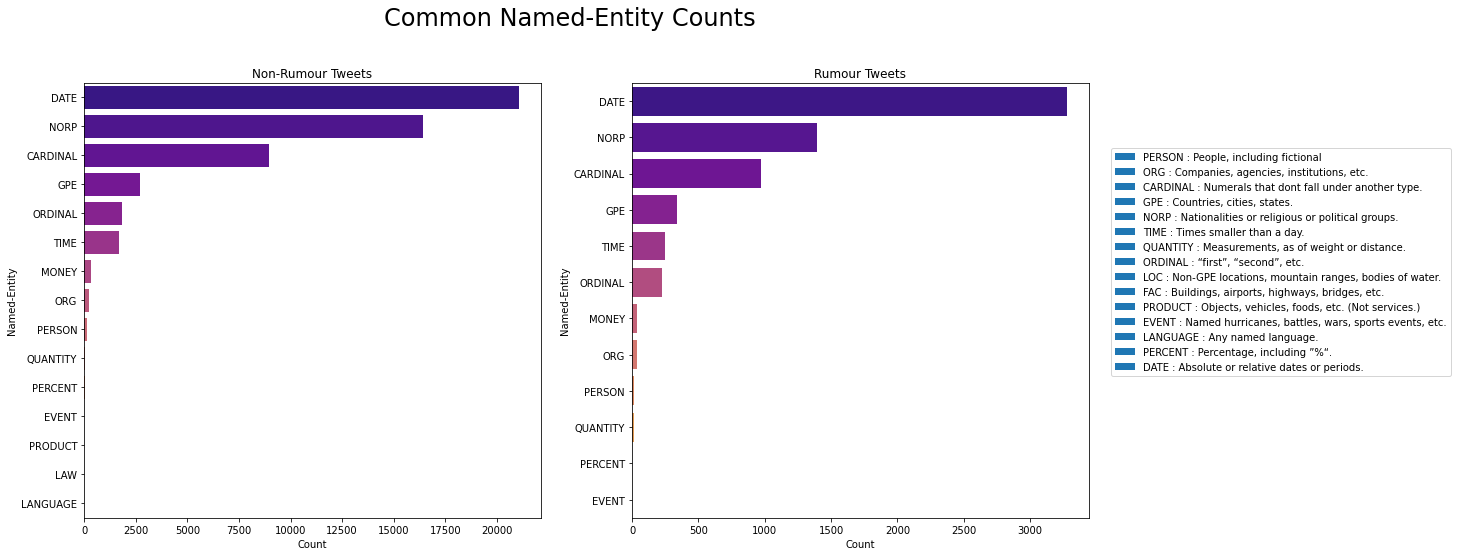

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non-Rumour Tweets')
axes[1].set_title('Rumour Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

## Analysis 2:  What are the popular hashtags of COVID-19 rumours and non-rumours? How much overlap or difference do they share?

In [90]:
hashtags = [
    covid_df[covid_df['label'] == 0]['hashtags'],
    covid_df[covid_df['label'] == 1]['hashtags']
]

In [91]:
hashtags[0][3]

[]

/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


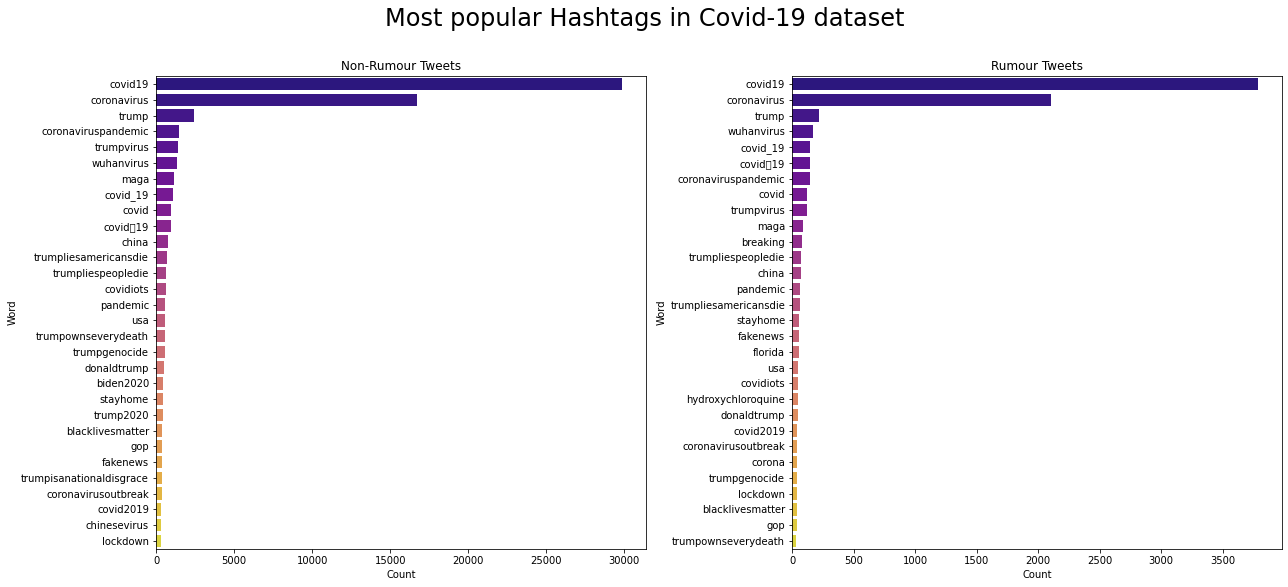

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(hashtags, axes):

    new = i.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
    
axes[0].set_title('Non-Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most popular Hashtags in Covid-19 dataset', fontsize=24, va='baseline')
plt.tight_layout()

In [93]:
counter = {}
for i, j in zip(hashtags, ['non_rumour' ,'rumour']):

    new = i.values.tolist()
    corpus = [word for i in new for word in i]

    counter[j] = Counter(corpus)

In [94]:
non_rumour = []
rumour = []

for key, value in counter['non_rumour'].most_common(n = 30):
    non_rumour.append(key)

for key, value in counter['rumour'].most_common(n = 30):
    rumour.append(key)

The following hashtags are present in the most-common hashtags of both tweet chains

In [95]:
intersection = set(non_rumour).intersection(set(rumour))

In [96]:
intersection

{'blacklivesmatter',
 'china',
 'coronavirus',
 'coronavirusoutbreak',
 'coronaviruspandemic',
 'covid',
 'covid19',
 'covid2019',
 'covid_19',
 'covidiots',
 'covidー19',
 'donaldtrump',
 'fakenews',
 'gop',
 'lockdown',
 'maga',
 'pandemic',
 'stayhome',
 'trump',
 'trumpgenocide',
 'trumpliesamericansdie',
 'trumpliespeopledie',
 'trumpownseverydeath',
 'trumpvirus',
 'usa',
 'wuhanvirus'}

The following hashtags are only present in one tweet chain (i.e. either in non-rumours or rumours)

In [97]:
difference = list(set(non_rumour) ^ set(rumour))

In [98]:
difference

['florida',
 'trumpisanationaldisgrace',
 'breaking',
 'chinesevirus',
 'hydroxychloroquine',
 'corona',
 'trump2020',
 'biden2020']

In [99]:
set(counter['non_rumour'].most_common(n = 30))

{('biden2020', 440),
 ('blacklivesmatter', 405),
 ('china', 736),
 ('chinesevirus', 340),
 ('coronavirus', 16747),
 ('coronavirusoutbreak', 355),
 ('coronaviruspandemic', 1487),
 ('covid', 982),
 ('covid19', 29861),
 ('covid2019', 341),
 ('covid_19', 1111),
 ('covidiots', 604),
 ('covidー19', 964),
 ('donaldtrump', 502),
 ('fakenews', 384),
 ('gop', 389),
 ('lockdown', 333),
 ('maga', 1133),
 ('pandemic', 577),
 ('stayhome', 439),
 ('trump', 2455),
 ('trump2020', 422),
 ('trumpgenocide', 550),
 ('trumpisanationaldisgrace', 363),
 ('trumpliesamericansdie', 713),
 ('trumpliespeopledie', 643),
 ('trumpownseverydeath', 553),
 ('trumpvirus', 1398),
 ('usa', 575),
 ('wuhanvirus', 1354)}

## Analysis 3: Do rumour source tweets convey a different sentiment/emotion to the non-rumour source tweets? What about their replies?

In [100]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bachfischer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [101]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [102]:
print(covid_df['source_tweet'][0])
sia.polarity_scores(covid_df['source_tweet'][0])

according to the new york times  warner bros  wanted to delay christopher nolan s tenet months ago due to the covid    pandemic but nolan refused to listen to any discussions  the studio kept the original release date to  keep [nolan] happy


{'neg': 0.092, 'neu': 0.743, 'pos': 0.165, 'compound': 0.6757}

### Check sentiment of source tweets

In [103]:
source_tweets = [
    covid_df[covid_df['label'] == 0]['source_tweet'],
    covid_df[covid_df['label'] == 1]['source_tweet']
]

In [104]:
def get_relative_scores_for_tweets(tweet_corpus):
    scores = {}
    scores['neg'] = 0
    scores['neu'] = 0
    scores['pos'] = 0

    for source_tweet in tweet_corpus:
        score = sia.polarity_scores(str(source_tweet))
        scores['neg'] += score['neg']
        scores['neu'] += score['neu']
        scores['pos'] += score['pos']
    
    number_of_tweets = len(tweet_corpus)
    scores['neg'] = scores['neg']/number_of_tweets
    scores['neu'] = scores['neu']/number_of_tweets
    scores['pos'] = scores['pos']/number_of_tweets
    
    return scores

In [105]:
non_rumour_sentiment_scores_source = get_relative_scores_for_tweets(source_tweets[0])
rumour_sentiment_scores_source = get_relative_scores_for_tweets(source_tweets[1])

In [106]:
print('Sentiment of non-rumour tweets:')
print(non_rumour_sentiment_scores_source)
print('Sentiment of rumour tweets:')
print(rumour_sentiment_scores_source)

Sentiment of non-rumour tweets:
{'neg': 0.09474698199788212, 'neu': 0.8122070596540765, 'pos': 0.08683078009177561}
Sentiment of rumour tweets:
{'neg': 0.091096568478591, 'neu': 0.8262131794716063, 'pos': 0.08115730337078657}


### Check sentiment of reply tweets

In [107]:
replies = [
    covid_df[covid_df['label'] == 0]['replies'],
    covid_df[covid_df['label'] == 1]['replies']
]

In [108]:
replies[0][3][0]

'let is not play blind that the work is fighting islamic religion through covid'

In [109]:
def get_scores_for_replies(tweet_chains):
    scores_for_all_replies = {}
    scores_for_all_replies['neg'] = 0
    scores_for_all_replies['neu'] = 0
    scores_for_all_replies['pos'] = 0
    
    for tweet_chain in tweet_chains:
        scores_for_current_replies = get_relative_scores_for_tweets(tweet_chain)
        scores_for_all_replies['neg'] += scores_for_current_replies['neg']
        scores_for_all_replies['neu'] += scores_for_current_replies['neu']
        scores_for_all_replies['pos'] += scores_for_current_replies['pos']
    
    number_of_tweets = len(tweet_chains)
    scores_for_all_replies['neg'] = scores_for_all_replies['neg']/number_of_tweets
    scores_for_all_replies['neu'] = scores_for_all_replies['neu']/number_of_tweets
    scores_for_all_replies['pos'] = scores_for_all_replies['pos']/number_of_tweets

In [110]:
non_rumour_sentiment_scores_replies = get_relative_scores_for_tweets(replies[0])
rumour_sentiment_scores_replies = get_relative_scores_for_tweets(replies[1])

In [111]:
print('Sentiment of replies for non-rumour tweets:')
print(non_rumour_sentiment_scores_replies)
print('Sentiment of rumour tweets:')
print(rumour_sentiment_scores_replies)

Sentiment of replies for non-rumour tweets:
{'neg': 0.09492170843628708, 'neu': 0.8322293681609605, 'pos': 0.07284376985527743}
Sentiment of rumour tweets:
{'neg': 0.08852991193440632, 'neu': 0.8420740965684785, 'pos': 0.06940874582447606}


## Analysis 4: What are the characteristics of rumour-creating users, and how do they differ compared to normal users?

In [112]:
sum(covid_df['retweet_count'])

63561557

Text(0.5, 0, 'Data')

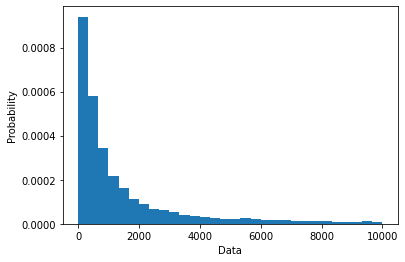

In [113]:
plt.hist(covid_df['retweet_count'], density=True, bins=30, range=(0, 10000))  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [114]:
def plot_characteristics_in_histogram(non_rumour_count, rumour_count, title):
    
    """A function for plotting numerical counts as a Histogram"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(non_rumour_count, ax=axes[0], color='#e74c3c')
    sns.distplot(rumour_count, ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel(title)
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non-Rumour Tweets')
    axes[1].set_xlabel(title)
    axes[1].set_title('Rumour Tweets')
    
    fig.suptitle(title, fontsize=24, va='baseline')
    
    fig.tight_layout()

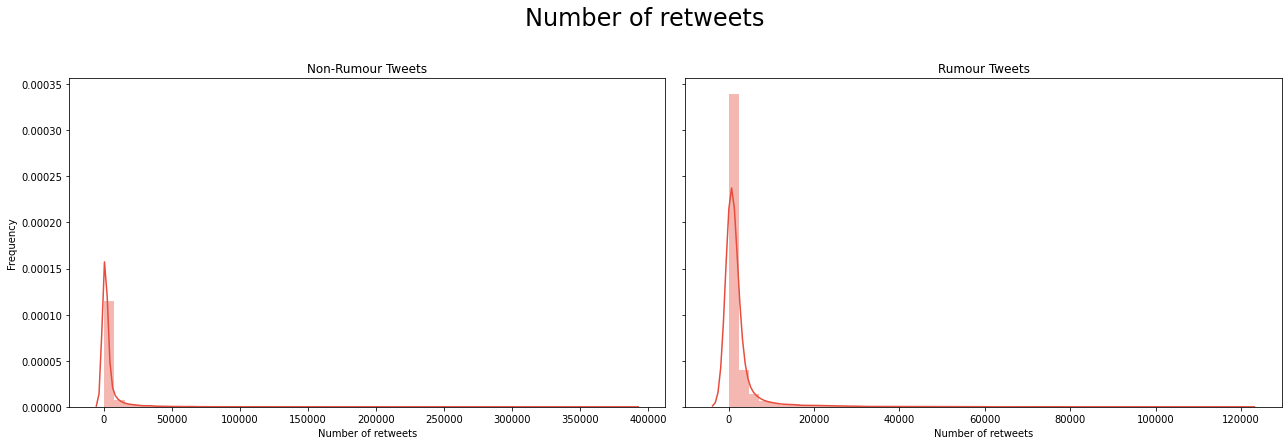

In [115]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['retweet_count'],
                           covid_df[covid_df['label'] == 1]['retweet_count'], 
                                 title = "Number of retweets")

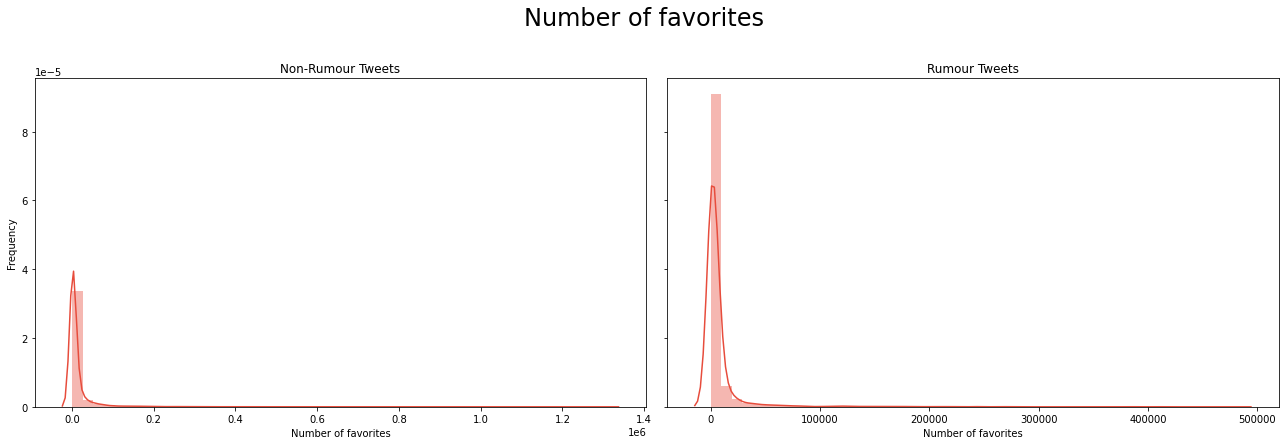

In [116]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['favorite_count'],
                           covid_df[covid_df['label'] == 1]['favorite_count'], 
                                 title = "Number of favorites")

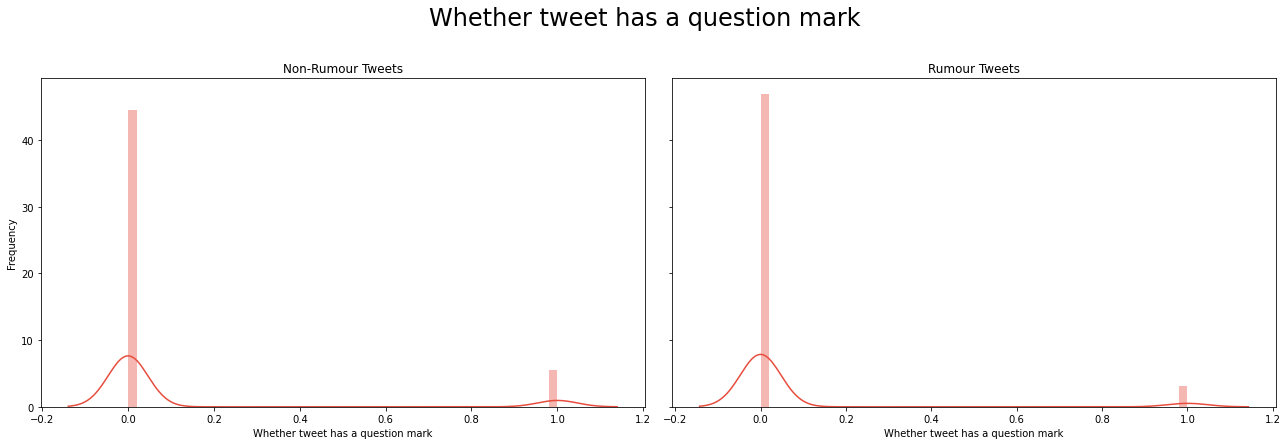

In [117]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['question_mark'],
                           covid_df[covid_df['label'] == 1]['question_mark'], 
                                 title = "Whether tweet has a question mark")

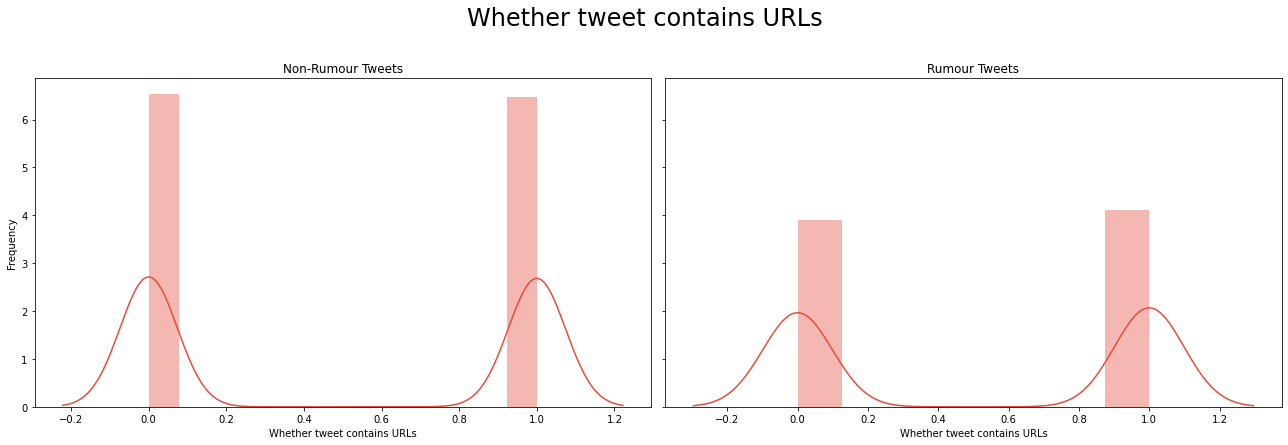

In [118]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['contains_url'],
                           covid_df[covid_df['label'] == 1]['contains_url'], 
                                 title = "Whether tweet contains URLs")

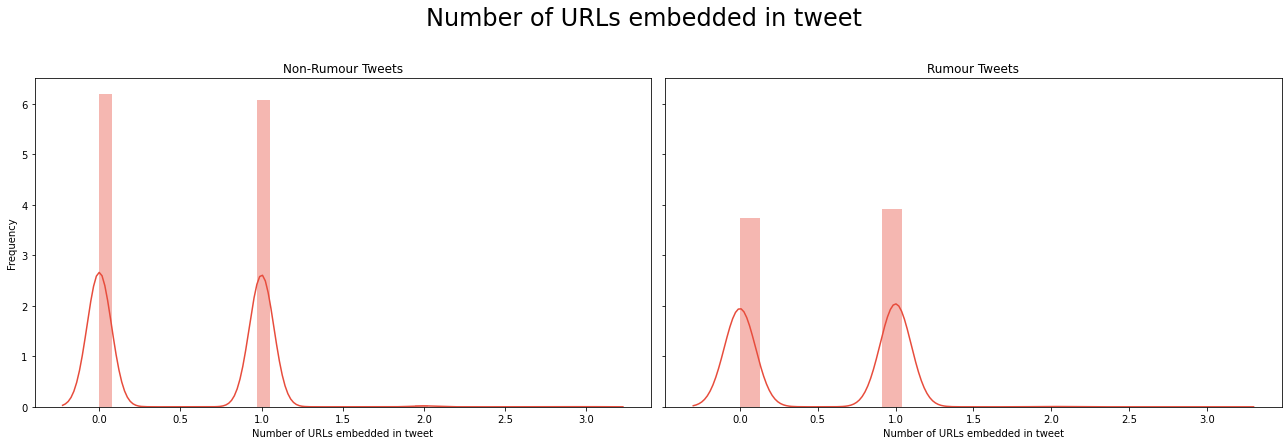

In [119]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['number_urls'],
                           covid_df[covid_df['label'] == 1]['number_urls'], 
                                 title = "Number of URLs embedded in tweet")

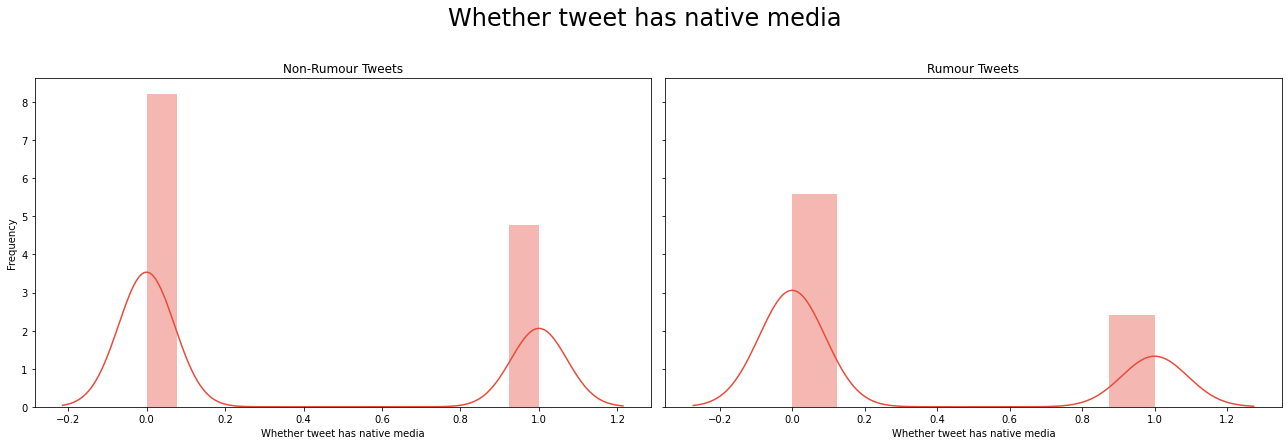

In [120]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['contains_media'],
                           covid_df[covid_df['label'] == 1]['contains_media'], 
                                 title = "Whether tweet has native media")

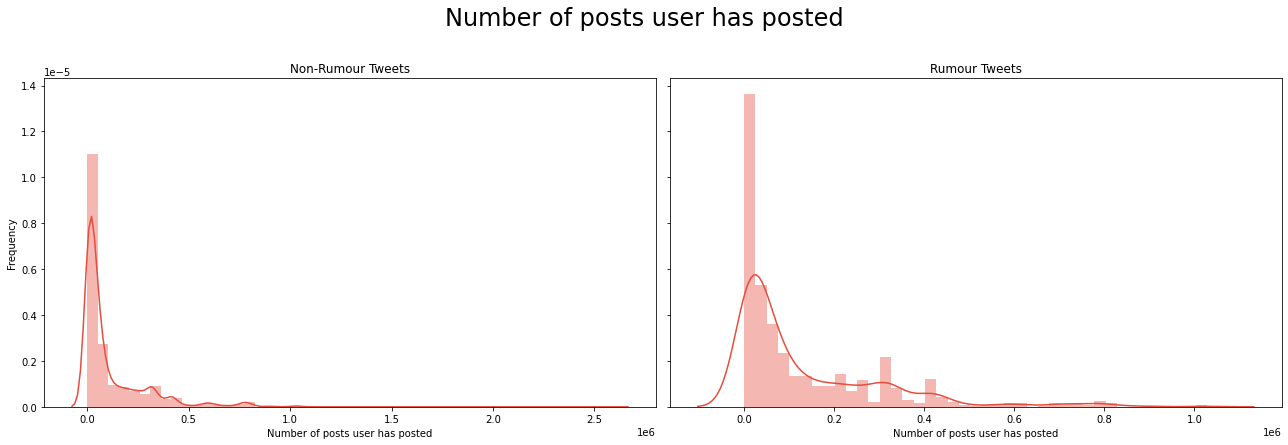

In [121]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['statuses_count'],
                           covid_df[covid_df['label'] == 1]['statuses_count'], 
                                 title = "Number of posts user has posted")

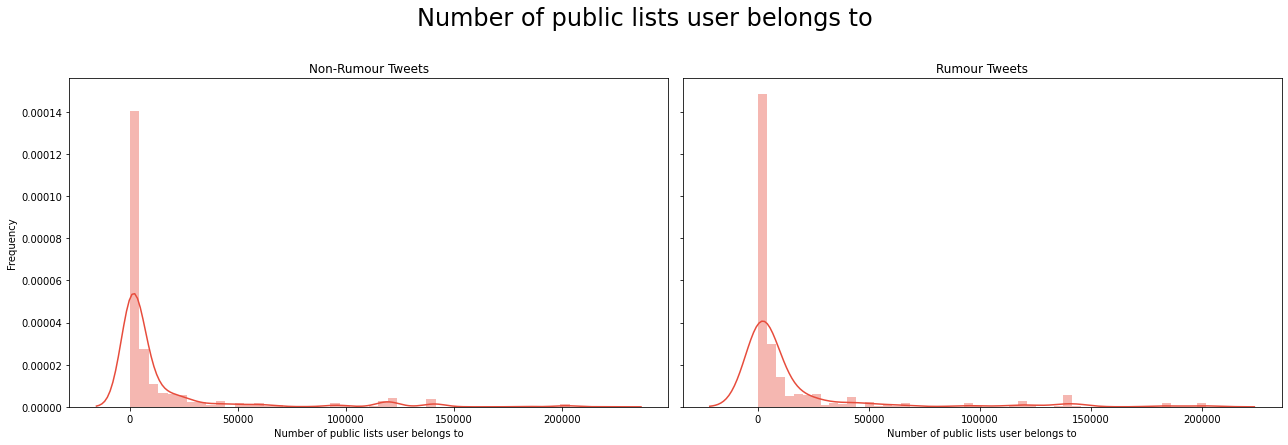

In [122]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['listed_count'],
                           covid_df[covid_df['label'] == 1]['listed_count'], 
                                 title = "Number of public lists user belongs to")

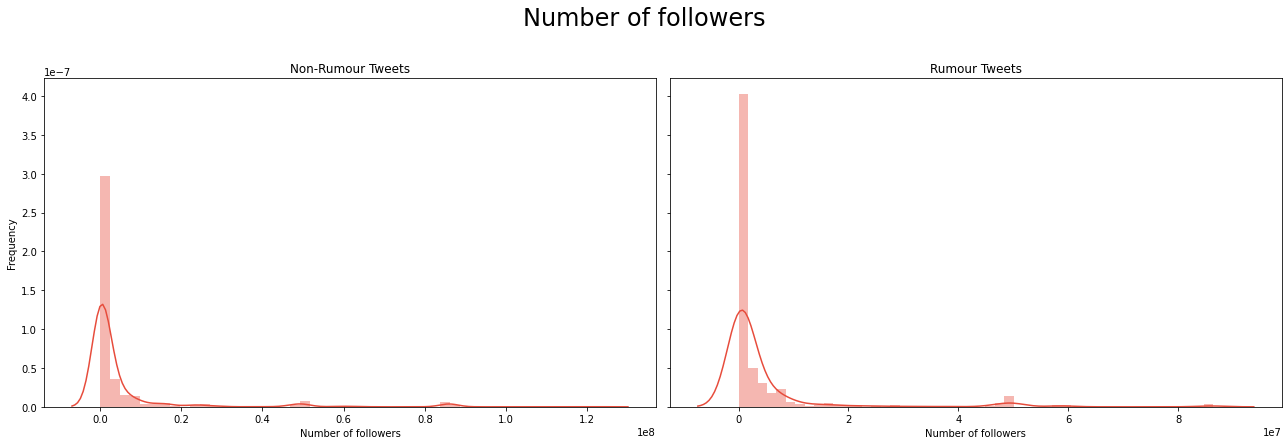

In [123]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['followers_count'],
                           covid_df[covid_df['label'] == 1]['followers_count'], 
                                 title = "Number of followers")

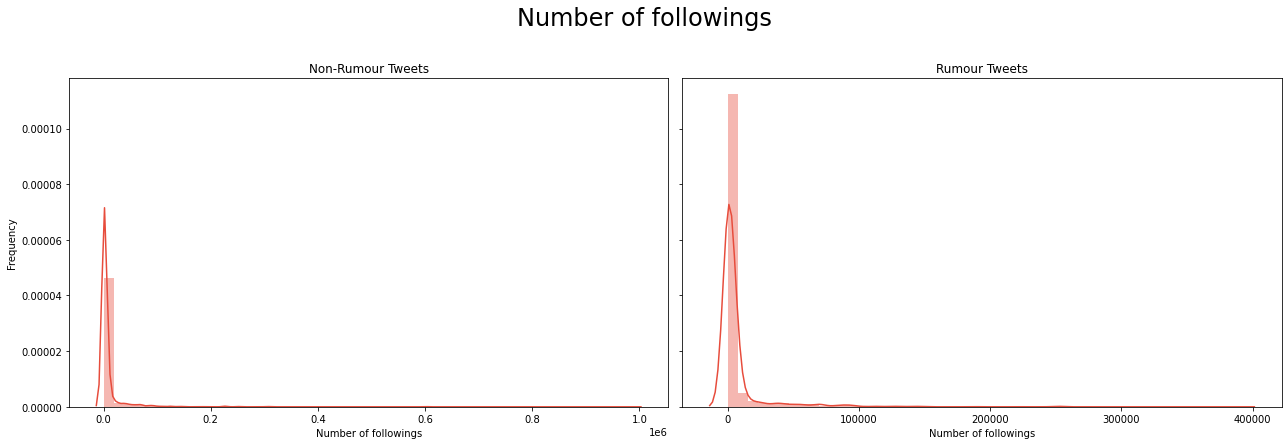

In [124]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['friends_count'],
                           covid_df[covid_df['label'] == 1]['friends_count'], 
                                 title = "Number of followings")

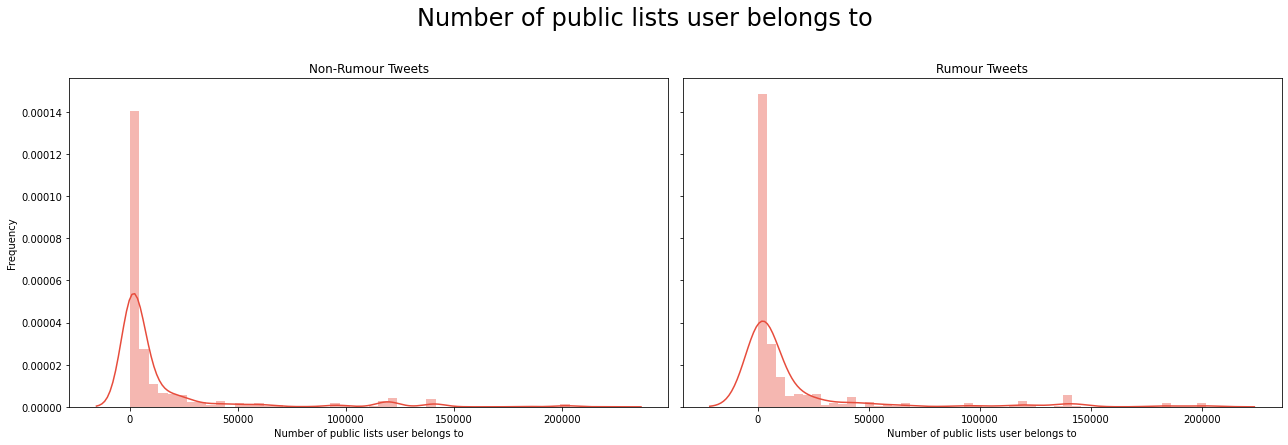

In [125]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['listed_count'],
                           covid_df[covid_df['label'] == 1]['listed_count'], 
                                 title = "Number of public lists user belongs to")

/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


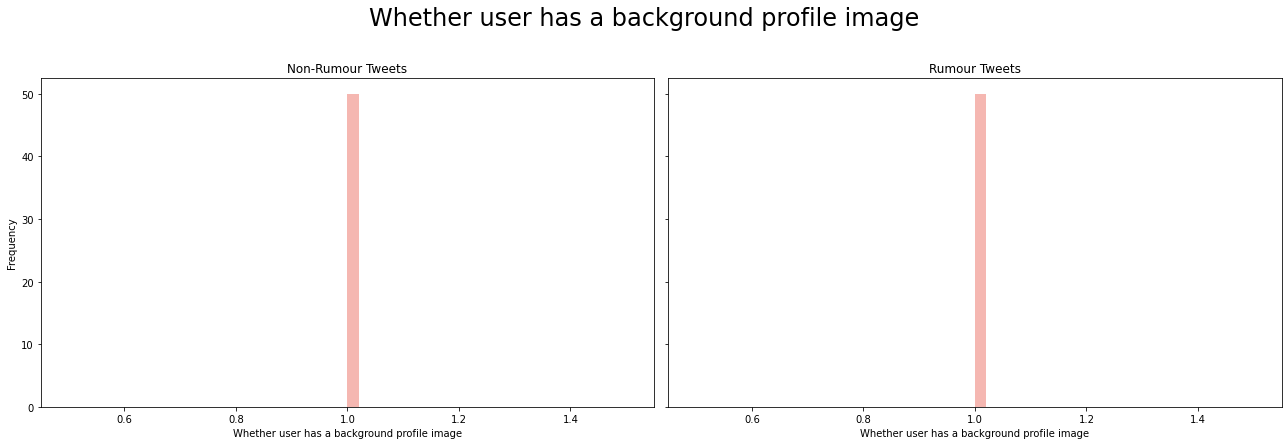

In [126]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['contains_profile_background_image'],
                           covid_df[covid_df['label'] == 1]['contains_profile_background_image'], 
                                 title = "Whether user has a background profile image")

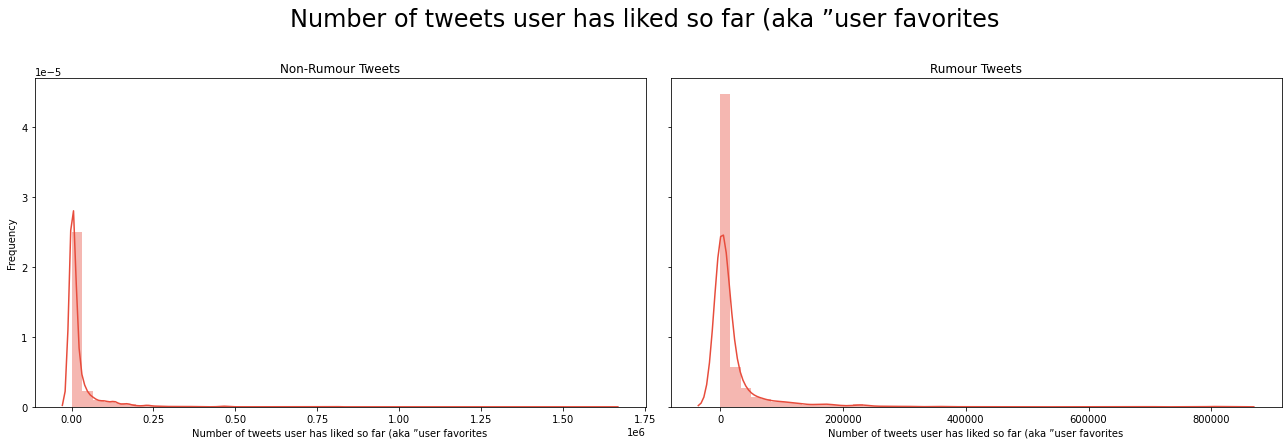

In [127]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['favourites_count'],
                           covid_df[covid_df['label'] == 1]['favourites_count'], 
                                 title = "Number of tweets user has liked so far (aka ”user favorites")

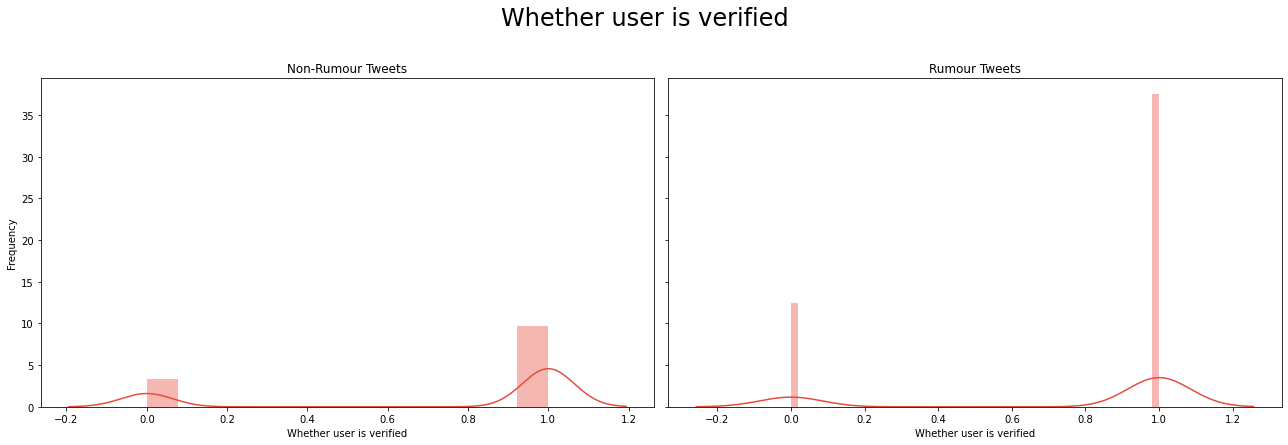

In [128]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['verified'],
                           covid_df[covid_df['label'] == 1]['verified'], 
                                 title = "Whether user is verified")

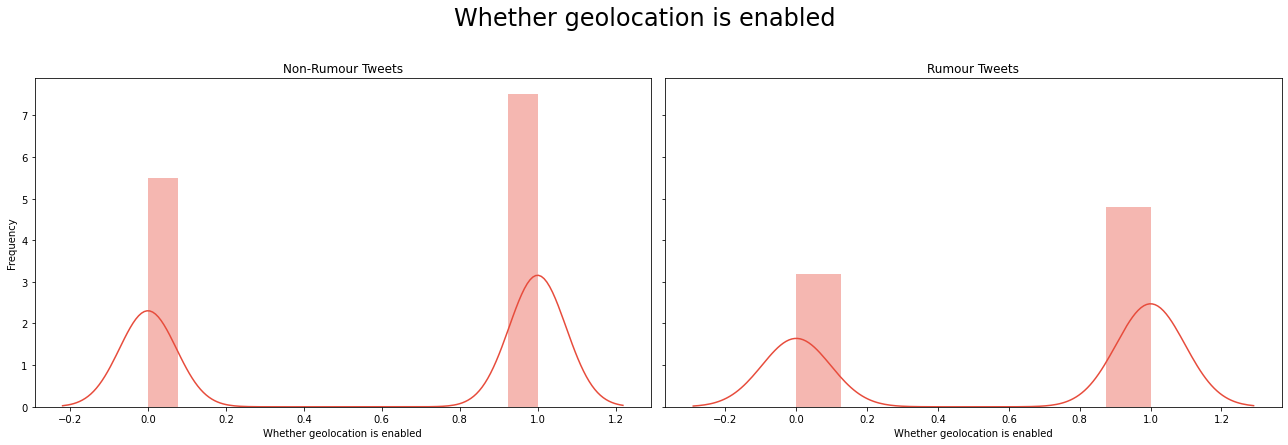

In [129]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['geo_enabled'],
                           covid_df[covid_df['label'] == 1]['geo_enabled'], 
                                 title = "Whether geolocation is enabled")

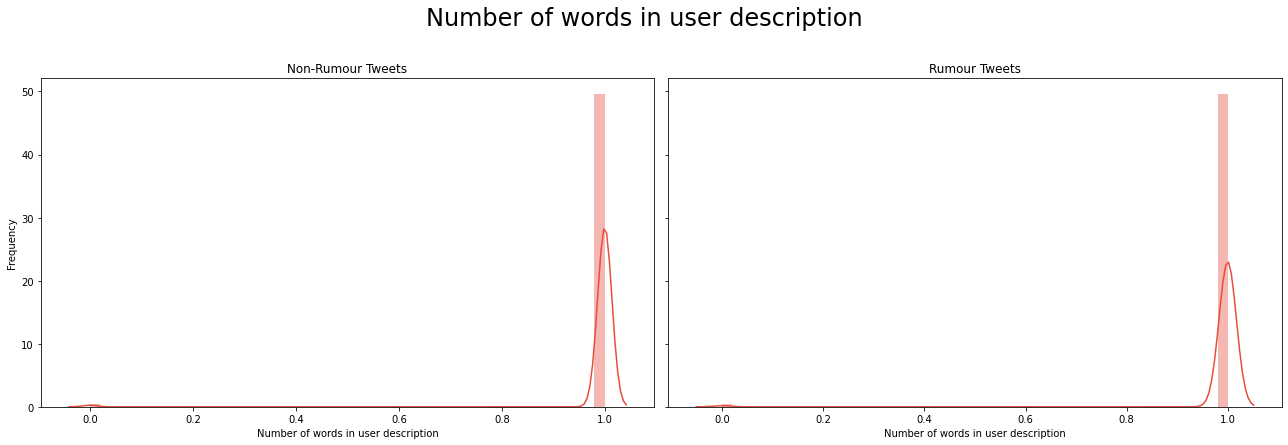

In [130]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['has_description'],
                           covid_df[covid_df['label'] == 1]['has_description'], 
                                 title = "Number of words in user description")

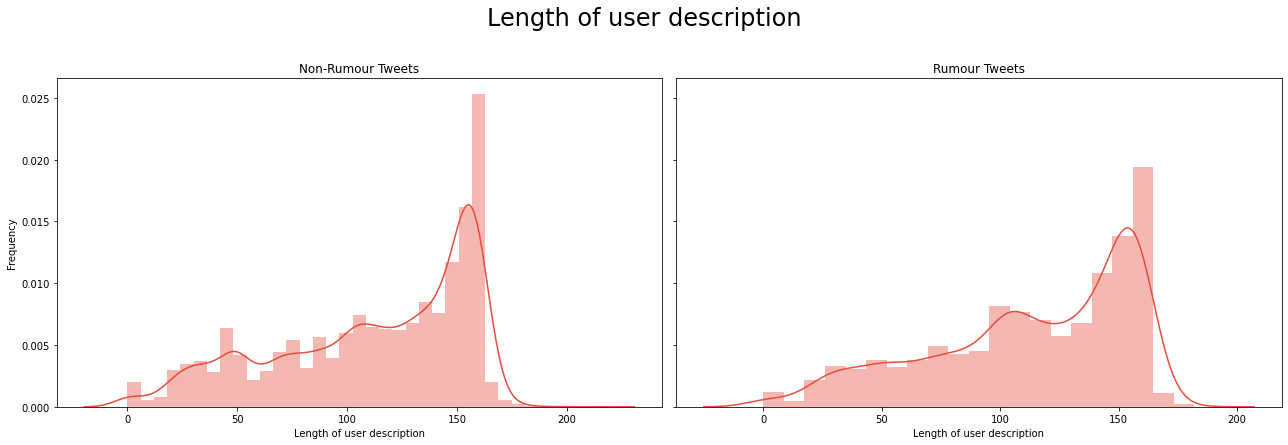

In [131]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['length_description'],
                           covid_df[covid_df['label'] == 1]['length_description'], 
                                 title = "Length of user description")